
# 📈 03b — Gradient Boosting (Regressão)

Este notebook testa **Gradient Boosting** para prever `IMDB_Rating`.

- Entrada: `data/movies.csv`
- Saída: `models/imdb_model_gb.pkl`
- Observação: o `GradientBoostingRegressor` do scikit-learn **não aceita entrada esparsa**.  
  Por isso, quando usamos texto (`Overview`), reduzimos TF‑IDF com **TruncatedSVD** (componentes densos) e usamos `OneHotEncoder(sparse_output=False)`.


In [1]:

# Imports
import warnings
warnings.filterwarnings("ignore")

import re, os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor



## 1) Carregar e preparar dados


In [2]:

DATA_PATH = "../data/movies.csv"
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)

def parse_runtime_to_minutes(runtime):
    if pd.isna(runtime):
        return np.nan
    if isinstance(runtime, (int, float)):
        return int(runtime) if runtime > 0 else np.nan
    m = re.search(r"(\d+)", str(runtime))
    return int(m.group(1)) if m else np.nan

def parse_gross_to_number(gross):
    if gross is None:
        return np.nan
    if isinstance(gross, (int, float)):
        return float(gross)
    s = str(gross).strip()
    if s == "":
        return np.nan
    s = s.replace(",", "").replace(".", "")
    return float(s) if s.isdigit() else np.nan

dfc = df.copy()
dfc["Runtime_min"] = dfc["Runtime"].apply(parse_runtime_to_minutes)
dfc["Gross_num"]   = dfc["Gross"].apply(parse_gross_to_number)
dfc["Gross_log1p"] = np.log1p(dfc["Gross_num"])
dfc["Released_Year_int"] = pd.to_numeric(dfc["Released_Year"], errors="coerce").astype("Int64")
dfc["Overview"] = dfc["Overview"].fillna("")


Shape: (999, 16)



## 2) Cenário e colunas
- `"post_release"`: usa `Meta_score` e `Gross`.
- `"early_stage"`: exclui `Gross` (e opcionalmente `Meta_score`).


In [3]:

SCENARIO = "post_release"   # "post_release" | "early_stage"
use_text = True             # Se True: TF-IDF -> SVD(200)

num_base = ["No_of_Votes", "Runtime_min", "Released_Year_int"]
cat_cols = ["Genre", "Certificate", "Director", "Star1", "Star2", "Star3", "Star4"]
text_col = "Overview"

if SCENARIO == "post_release":
    num_cols = num_base + ["Meta_score", "Gross_log1p"]
else:
    num_cols = num_base
    # Opcional: incluir Meta_score se quiser pós-crítica em early-stage
    # num_cols += ["Meta_score"]

y = dfc["IMDB_Rating"].astype(float)
X = dfc[num_cols + cat_cols + [text_col]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (799, 13)  Test: (200, 13)



## 3) Pipeline (pré-processamento + GradientBoosting)
- Numéricas → `SimpleImputer(median)`
- Categóricas → `SimpleImputer(most_frequent)` + `OneHotEncoder(sparse_output=False)`
- Texto → `TF-IDF` + `TruncatedSVD(n_components=200)` (saída densa)


In [4]:

from sklearn.preprocessing import FunctionTransformer

num_pipe = SimpleImputer(strategy="median")
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

if use_text:
    txt_pipe = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=8000, ngram_range=(1,2), stop_words="english")),
        ("svd", TruncatedSVD(n_components=200, random_state=42))
    ])
    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
            ("txt", txt_pipe, text_col)
        ],
        remainder="drop"
    )
else:
    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop"
    )

est = GradientBoostingRegressor(random_state=42)
pipe = Pipeline([("pre", pre), ("est", est)])
pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)
rmse = mean_squared_error(y_test, preds, squared=False)
mae  = mean_absolute_error(y_test, preds)
r2   = r2_score(y_test, preds)
print(f"Baseline GB — RMSE: {rmse:.3f} | MAE: {mae:.3f} | R²: {r2:.3f}")


Baseline GB — RMSE: 0.210 | MAE: 0.171 | R²: 0.329



## 4) Grid Search (pequeno)


In [5]:

param_grid = {
    "est__n_estimators": [200, 400],
    "est__learning_rate": [0.05, 0.1],
    "est__max_depth": [2, 3],
    "est__subsample": [0.8, 1.0]
}
gs = GridSearchCV(pipe, param_grid, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
best = gs.best_estimator_
yp = best.predict(X_test)
rmse = mean_squared_error(y_test, yp, squared=False)
mae  = mean_absolute_error(y_test, yp)
r2   = r2_score(y_test, yp)
print("Best params:", gs.best_params_)
print(f"GB (tuned) — RMSE: {rmse:.3f} | MAE: {mae:.3f} | R²: {r2:.3f}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best params: {'est__learning_rate': 0.05, 'est__max_depth': 2, 'est__n_estimators': 400, 'est__subsample': 1.0}
GB (tuned) — RMSE: 0.211 | MAE: 0.170 | R²: 0.322



## 5) Salvamento `.pkl`


In [6]:

os.makedirs("models", exist_ok=True)
with open("models/imdb_model_gb.pkl", "wb") as f:
    pickle.dump(best, f)
print("Salvo em models/imdb_model_gb.pkl")


Salvo em models/imdb_model_gb.pkl



## 6) Plot de diagnóstico (Previsto vs Real)


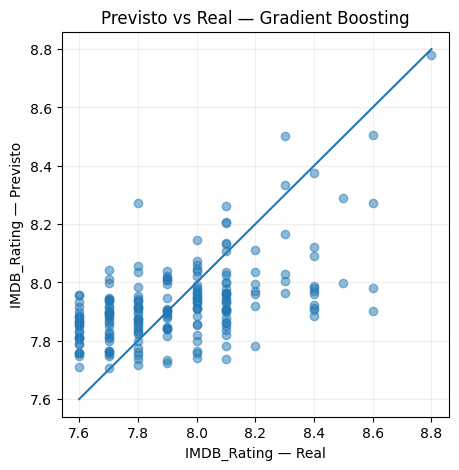

In [7]:

fig = plt.figure(figsize=(5,5))
plt.scatter(y_test, yp, alpha=0.5)
plt.xlabel("IMDB_Rating — Real")
plt.ylabel("IMDB_Rating — Previsto")
plt.title("Previsto vs Real — Gradient Boosting")
mn, mx = float(min(y_test.min(), yp.min())), float(max(y_test.max(), yp.max()))
plt.plot([mn, mx], [mn, mx])
plt.grid(True, alpha=0.2)
plt.show()
